# ニューラルネットワークの実装と手書き数字の認識

ニューラルネットワークによる機械学習の原理を理解するとともに勾配法や自然勾配法の実装をし，手書き数字の認識を行う．

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

## ニューラルネットワークの学習原理と実装

### 仮説とコスト関数の計算：順伝播

特徴量ベクトルを$\vec{x} =(x_1 ,\dots ,x_n)^\mathrm{T}$，ターゲットの1-hot表現を$\vec{y} =(y_1 ,\dots ,y_C)^\mathrm{T}$とする．1-hot表現$\vec{y}$は$C$次元ベクトルであり，クラスのラベルが$c$ならば$\vec{y}$は第$c$成分のみ1で他が0のベクトルとなる．特徴量$\vec{x}$とターゲット$\vec{y}$は何らかの真の分布$p(\vec{x} ,\vec{y})=p(\vec{x})p(\vec{y} \vert\vec{x})$に従う．

ニューラルネットワークを用いて分布$p(\vec{y} \vert\vec{x})$を推定したい．$L+1$層のニューラルネットワークは次のように与えられる：
\begin{align}
& \vec{a}^{(0)} =\vec{x} , \\
& \left\{
\begin{aligned}
& a_0^{(l)} =1,\quad a^{(l)} =
\begin{pmatrix}
a_0^{(l)} \\
\vec{a}^{(l)}
\end{pmatrix}
, \\
& (\vec{z}^{(l+1)})^\mathrm{T} =(a^{(l)})^\mathrm{T} \Theta ^{(l)} , \\
& \vec{a}^{(l+1)} =\vec{\phi}^{(l+1)} (\vec{z}^{(l+1)})
\end{aligned}
\right.\quad (l=0,\dotsc,L-1), \\
& \vec{h} (\vec{x} \vert\Theta )=\vec{a}^{(L)} .
\end{align}
$l$は層の番号を表し，$l=0$は入力層，$l=1,\dots ,L-1$は隠れ層，$l=L$は出力層である．入力変数は特徴量ベクトル$\vec{x} =(x_1 ,\dots ,x_n)^\mathrm{T}$であり，出力変数は仮説$\vec{h} (\vec{x} \vert\Theta )=(h_1 (\vec{x} \vert\Theta ) ,\dots ,h_C (\vec{x} \vert\Theta ))^\mathrm{T}$である．パラメータ$\Theta$は$L$個の行列（重み）$\Theta ^{(l)}$から成る：$\Theta =(\Theta ^{(l)})_{l=0,1,\dots ,L-1}$. 第$l$層には$n_l$次元変数$\vec{a}^{(l)} =(a_1^{(l)} ,\dots ,a_{n_l}^{(l)})^\mathrm{T}$が割り当てられている．定義から$n_0 =n$, $n_L =C$である．中括弧で括られた漸化式は第$l$層の変数$\vec{a}^{(l)}$から第$l+1$層の変数$\vec{a}^{(l+1)}$への変換を示しており，漸化式を次々に計算する過程は順伝播と呼ばれる．漸化式の第1式は$\vec{a}^{(l)}$に0番目の成分$a_0^{(l)} =1$を加える操作であり，その結果を$a^{(l)}$とする（成分のインデックスが1から始まるベクトルは矢印をつけて表し，インデックスが0から始まるベクトルには矢印をつけない）．第2式は$(n_l +1)\times n_{l+1}$行列$\Theta ^{(l)} =({\Theta ^{(l)\mu}}_j)_{\mu =0,1,\dots ,n_l ;j=1,\dots ,n_{l+1}}$（アルファベット$i,j,\dots$は1から始まる（0を含まない）添字，ギリシャ文字$\mu ,\nu ,\dots$は0から始まる添字とする）をかける線形変換であり，その結果を$\vec{z}^{(l+1)} =(z_1^{(l+1)} ,\dots ,z_{n_{l+1}}^{(l+1)})^\mathrm{T}$とする．第3式は$\vec{z}^{(l+1)}$に活性化関数$\vec{\phi}^{(l+1)} =(\phi _1^{(l+1)} ,\dots ,\phi _{n_{l+1}}^{(l+1)})^\mathrm{T}$を作用させる操作であり，その結果が第$l+1$層の変数$\vec{a}^{(l+1)}$である．

隠れ層$l=1,\dots ,L-1$の活性化関数$\vec{\phi}^{(l)}$はすべての隠れ層について同じ関数$\phi$とし，引数の成分ごとに作用するとする：
$$
\phi _i^{(l)} (\vec{z})=\phi (z_i)\quad (l=1,\dots ,L-1).
$$
隠れ層の活性化関数$\phi$はシグモイド関数
$$
\phi (z)=\frac{1}{1+e^{-z}}
$$
やReLU関数
$$
\phi (z)=\max\{ z,0\}
$$
にとることが多い．一方，出力層$l=L$の活性化関数$\vec{\phi}^{(L)}$はソフトマックス関数$\vec{S} =(S_1 ,\dots ,S_C)^\mathrm{T}$とする：
$$
\phi _c^{(L)} (\vec{z})=S_c (\vec{z})=\frac{e^{z_c}}{\sum _{c'=1}^C e^{z_{c'}}} .
$$

重みが$\Theta$であるとき，特徴量$\vec{x}$に対してターゲットが$\vec{y}$となる確率が次のように与えられると推定しよう：
$$
p(\vec{y} \vert\vec{x} ,\Theta )=\prod _{c=1}^C h_c (\vec{x} \vert\Theta )^{y_c} .
$$
すなわち，ターゲット$\vec{y}$のクラスが$c$である確率が$h_c (\vec{x} \vert\Theta )$である．したがって，仮説$\vec{h} (\vec{x} \vert\Theta )$はターゲットのクラスに関する確率ベクトルとなっている．上式の分布は規格化条件
$$
\sum _{\vec{y} =(1,0,\dots ,0)^\mathrm{T} ,(0,1,0,\dots ,0)^\mathrm{T} ,\dots ,(0,\dots ,0,1)^\mathrm{T}} p(\vec{y} \vert\vec{x} ,\Theta )=1
$$
を満たす．実際には$h_\Theta (\vec{x})$の成分が最も大きくなるようなインデックス$c$がデータの属するクラスであると予測する．

コスト関数$J(\Theta )$は，2つの分布$p(\vec{y} \vert\vec{x})$, $p(\vec{y} \vert\vec{x} ,\Theta )$の条件付きKullback-Leipler (KL) ダイバージェンス
$$
\mathrm{E}_{p(\vec{x} ,\vec{y})} \left[\log\frac{p(\vec{y} \vert\vec{x})}{p(\vec{y} \vert\vec{x} ,\Theta )} \right] =\mathrm{E}_{p(\vec{x} ,\vec{y})} [\log p(\vec{y} \vert\vec{x})]-\mathrm{E}_{p(\vec{x} ,\vec{y})} [\log p(\vec{y} \vert\vec{x} ,\Theta )]
$$
から第1項の定数を除いたもの，すなわち交差エントロピーとする：
$$
J(\Theta )=-\mathrm{E}_{p(\vec{x} ,\vec{y})} [\log p(\vec{y} \vert\vec{x} ,\Theta )]=-\mathrm{E}_{p(\vec{x} ,\vec{y})} \left[\sum _{c=1}^C y_c \log h_c (\vec{x} \vert\Theta )\right] .
$$

### コスト関数の勾配計算：誤差逆伝播法

次にコスト関数の勾配
$$
\frac{\partial J(\Theta )}{\partial {\Theta ^{(l)\mu}}_j} =\mathrm{E}_{p(\vec{x} ,\vec{y})} \left[\frac{\partial}{\partial {(\Theta ^{(l)})^\mu}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))\right]
$$
を求めよう．偏微分の連鎖率を用いると，対数尤度関数の勾配は次のように表される：
$$
\frac{\partial}{\partial {\Theta ^{(l)\mu}}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\frac{\partial z_{j_{l+1}}^{(l+1)}}{\partial {\Theta ^{(l)\mu}}_j} \left(\prod _{l'=l+1}^{L-1} \frac{\partial a_{i_{l'}}^{(l')}}{\partial z_{j_{l'}}^{(l')}} \frac{\partial z_{j_{l'+1}}^{(l'+1)}}{\partial a_{i_{l'}}^{(l')}} \right)\frac{\partial a_{i_L}^{(L)}}{\partial z_{j_L}^{(L)}} \frac{\partial}{\partial a_{i_L}^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta )).
$$
ただし，$l'=l+1,\dots ,L-1$に関する積は$l=L-1$のとき1とする．また，2回繰り返された添字（上式では$i_{l+1} \dots ,i_L$, $j_{l+1} ,\dots ,j_L$）について和をとるEinsteinの縮約規則を用いた．ここで
$$
\delta ^{(l+1)j_{l+1}} =\frac{\partial}{\partial z_{j_{l+1}}^{(l+1)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\left(\prod _{l'=l+1}^{L-1} \frac{\partial a_{i_{l'}}^{(l')}}{\partial z_{j_{l'}}^{(l')}} \frac{\partial z_{j_{l'+1}}^{(l'+1)}}{\partial a_{i_{l'}}^{(l')}} \right)\frac{\partial a_{i_L}^{(L)}}{\partial z_{j_L}^{(L)}} \frac{\partial}{\partial a_{i_L}^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))
$$
とおくと，次式が得られる：
$$
\frac{\partial}{\partial {\Theta ^{(l)\mu}}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\frac{\partial z_{j_{l+1}}^{(l+1)}}{\partial {\Theta ^{(l)\mu}}_j} \delta ^{(l+1)j_{l+1}} =a_\mu ^{(l)} \delta ^{(l+1)j} .
$$

$\vec{\delta}^{(l)} =(\delta ^{(l)1} ,\dots ,\delta ^{(l)n_l})^\mathrm{T}$ ($l=1,\dots ,L$) は「誤差」と呼ばれる．出力層$l=L$の誤差ベクトル$\vec{\delta}^{(L)}$は仮説とターゲットの差となる：
\begin{align}
\delta ^{(L)c} & =\frac{\partial}{\partial z_c^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\frac{\partial a_{c'}^{(L)}}{\partial z_c^{(L)}} \frac{\partial}{\partial a_{c'}^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta )) \\
& =-\sum _{c'=1}^C \frac{y_{c'}}{a_{c'}^{(L)}} a_{c'}^{(L)} (\delta _{c'c} -a_c^{(L)})=\sum _{c'=1}^C y_{c'} (a_c^{(L)} -\delta _{c'c}) \\
& =a_c^{(L)} -y_c \\
\iff\vec{\delta}^{(L)} & =\vec{a}^{(L)} -\vec{y} .
\end{align}
ここでKroneckerのデルタを$\delta _{c'c}$と書いた．また，隠れ層$l=1,\dots ,L-1$の誤差ベクトル$\vec{\delta}^{(l)}$は次の漸化式から計算できる：
$$
\delta ^{(l)j_l} =\frac{\partial a_{i_l}^{(l)}}{\partial z_{j_l}^{(l)}} \frac{\partial z_{j_{l+1}}^{(l+1)}}{\partial a_{i_l}^{(l)}} \delta ^{(l+1)j_{l+1}} =\frac{\partial\phi _{i_l}^{(l)} (\vec{z}^{(l)})}{\partial z_{j_l}^{(l)}} {\Theta ^{(l)i_l}}_{j_{l+1}} \delta ^{(l+1)j_{l+1}} \iff\vec{\delta}^{(l)} =\phi '(\vec{z}^{(l)})*(\tilde{\Theta}^{(l)} \vec{\delta} ^{(l+1)}).
$$
ここで$\phi '(\vec{z}^{(l)})$は，$\vec{z}^{(l)}$の各成分を引数に持つ，隠れ層の活性化関数$\phi$の導関数である．また，$\tilde{\Theta}^{(l)} =({\Theta ^{(l)i}}_j)_{i=1,\dots ,n_l;j=1,\dots ,n_{l+1}}$は$\Theta ^{(l)}$から第0行を除いて得られる行列であり，$*$はベクトルの成分ごとの積を表す．

以上で導いた式を用いてコスト関数の勾配を計算することができる．上の$\vec{\delta}^{(l)}$に関する漸化式は誤差を出力層から入力に近い層に向かって逆に伝播させる過程と見なせるため，逆伝播と呼ばれる．また，このように誤差やコスト関数の勾配を求める方法は誤差逆伝播法と呼ばれる．

### 誤差逆伝播法の転送行列を用いた定式化

誤差ベクトルの逆伝播は以下のように転送行列を用いても定式化できる．隠れ層$l=1,\dots ,L-1$に対して転送行列$t^{(l)} =({t^{(l)j_l}}_{j_{l+1}})_{j_l =1,\dots ,n_l ;j_{l+1} =1,\dots ,n_{l+1}}$を
$$
{t^{(l)j_l}}_{j_{l+1}} =\frac{\partial\phi _{i_l}^{(l)} (\vec{z}^{(l)})}{\partial z_{j_l}^{(l)}} {\Theta ^{(l)i_l}}_{j_{l+1}} .
$$
により定義する．さらに，第$l'$層から第$l$層への累積転送行列$T^{(l,l')} =({T^{(l,l')j_l}}_{j_{l'}})_{j_l =1,\dots ,n_l ;j_{l'} =1,\dots ,n_{l'}}$を
$$
{T^{(l,l')j_l}}_{j_{l'}} = {t^{(l)j_l}}_{j_{l+1}} \cdots {t^{(l'-1)j_{l'-1}}}_{j_{l'}} \iff T^{(l,l')} =t^{(l)} \cdots t^{(l'-1)}
$$
により定義する．ただし，$l=l'$のときは${T^{(l,l')j_l}}_{j_{l'}} =\delta _{j_{l'}}^{j_l}$（Kroneckerのデルタ）とする．このとき，
$$
\delta ^{(l)j} = {T^{(l,L)j}}_c \delta ^{(L)c} \iff\vec{\delta}^{(l)} =T^{(l,L)} \vec{\delta}^{(L)}
$$
が成り立つ．したがって，出力層の誤差ベクトル$\vec{\delta}^{(L)}$に出力層から第$l$層への累積転送行列$T^{(l,L)}$かけることで，第$l$層の誤差ベクトル$\vec{\delta}^{(l)}$が求まる．また，漸化式
$$
T^{(l,L)} =t^{(l)} T^{(l+1,L)} .
$$
に注目すると，転送行列$t^{(l)}$は第$l+1$層から第$l$層へ誤差を転送する行列であることがわかる．よって，あらかじめ局所的な転送行列の組$t=(t^{(l)})_{l=1,\dots ,L-1}$および出力層から隠れ層への累積転送行列の組$T=(T^{(l,L)})_{l=1,\dots ,L}$を計算しておき，後から各層の誤差ベクトルを求めることができる．この計算法は後述する自然勾配法の実行のために便利である．

### 正則化および最大事後確率推定との関係

実際の計算では真の分布$p(x,y)$がわからないため，期待値$\mathrm{E}_{p(x,y)} [\cdot ]$は訓練データに関する平均値に置き換える：
\begin{align}
J(\Theta ) & =-\frac{1}{D} \sum _{d=1}^D \log p(\vec{y}^{[d]} \vert\vec{x}^{[d]} ,\Theta ), \\
\frac{\partial J(\Theta )}{\partial {\Theta ^{(l)\mu}}_j} & =-\frac{1}{D} \sum _{d=1}^D \frac{\partial}{\partial {\Theta ^{(l)\mu}}_j} \log p(\vec{y}^{[d]} \vert\vec{x}^{[d]} ,\Theta ).
\end{align}
ここで，$[d]$ ($d=1,\dots ,D$) は訓練データのインデックスを表す．

正則化を行う場合，コスト関数とその勾配は次のように表される：
\begin{align}
J_\mathrm{r} (\Theta ) & =J(\Theta )+\frac{1}{2D} \sum _{l=0}^{L-1} \sum _{\mu =0}^{n_l} \sum _{j=1}^{n_{l+1}} {M^{(l)\mu}}_j ({\Theta ^{(l)\mu}}_j)^2 , \\
\frac{\partial J_\mathrm{r} (\Theta )}{\partial {\Theta ^{(l)\mu}}_j} & =\frac{\partial J(\Theta )}{\partial {\Theta ^{(l)\mu}}_j} +\frac{1}{D} {M^{(l)\mu}}_j {\Theta ^{(l)\mu}}_j .
\end{align}
正則化パラメータ$M=(M^{(l)})_{l=0,1,\dots ,L-1} =({M^{(l)\mu}}_j)_{l=0,1,\dots ,L-1;\mu =0,1,\dots ,n_l ;j=1,\dots ,n_{l+1}}$はハイパーパラメータである．正則化項をつけたコスト関数$J_\mathrm{r} (\Theta )$の最小化は，与えられたデータ$\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} _{d=1,\dots ,D}$とハイパーパラメータ$M$に対して事後分布$p(\Theta\vert\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,M)$を最大化するパラメータ$\Theta$の推定，すなわち最大事後確率推定と見なせる．実際，各データが独立同分布$p(\vec{x} ,\vec{y})$に従って生成されると仮定すると，
$$
p(\Theta\vert\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,M)=\frac{p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,\Theta\vert M)}{p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} )}
$$
および
$$
p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,\Theta\vert M)=p(\Theta\vert M)p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} \vert\Theta )=p(\Theta\vert M)\prod _{d=1}^D p(\vec{x}^{[d]} ,\vec{y}^{[d]} \vert\Theta )
$$
が成り立つので，ハイパーパラメータ$M$に対するパラメータ$\Theta$の分布を正規分布
$$
p(\Theta\vert M)=\prod _{l=0}^{L-1} \prod _{\mu =0}^{n_l} \prod _{j=1}^{n_{l+1}} \sqrt{\frac{{M^{(l)\mu}}_j}{2\pi}} \exp\left( -\frac{1}{2} {M^{(l)\mu}}_j ({\Theta ^{(l)\mu}}_j)^2 \right)
$$
とすると，
$$
\mathop{\mathrm{arg\, max}}_\Theta p(\Theta\vert\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,M)=\mathop{\mathrm{arg\, max}}_\Theta J_\mathrm{r} (\Theta )
$$
が導かれる．なお，正則化なしのコスト関数の最小化は尤度関数$p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\}\vert\Theta )$を最大化するパラメータ$\Theta$の推定，すなわち最尤推定と見なせる：
$$
\mathop{\mathrm{arg\, max}}_\Theta p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\}\vert\Theta )=\mathop{\mathrm{arg\, max}}_\Theta J(\Theta ).
$$

以下では正則化パラメータを${M^{(l)\nu}}_j =\mu$とする．

In [2]:
# 行列の左にすべての成分が1の列を挿入する関数
def insert1column(X):
    X_ext = np.insert(X,0,1,axis=1)
    return(X_ext)

In [3]:
# アフィン変換
class affine:
    
    # 初期化
    def __init__(self,W):
        self.weight = W
        self.in_ext = None
    
    # 順伝播
    def forward(self,X):
        self.in_ext = insert1column(X)
        Y = self.in_ext @ self.weight
        return(Y)
    
    # 逆伝播
    def backward(self,T):
        U = np.einsum('ij,djk->dik',self.weight[1:,:],T,optimize=True)
        return(U)

In [4]:
# シグモイド活性化関数
class sigmoid:
    
    # 初期化
    def __init__(self):
        self.out = None
    
    # 順伝播
    def forward(self,X):
        Y = 1 / (1 + np.exp(-X))
        self.out = Y
        return(Y)
    
    # 逆伝播
    def backward(self,T):
        Y_X = self.out * (1 - self.out)
        U = np.einsum('di,dij->dij',Y_X,T,optimize=True)
        return(U)

In [5]:
# ReLU活性化関数
class relu:
    
    # 初期化
    def __init__(self):
        self.in_mask = None
    
    # 順伝播
    def forward(self,X):
        self.in_mask = (X <= 0)
        Y = X.copy()
        Y[self.in_mask] = 0
        return(Y)
    
    # 逆伝播
    def backward(self,T):
        T[self.in_mask,:] = 0
        U = T
        return(U)

In [6]:
# ソフトマックス関数
def softmax(X):
    X -= np.amax(X,axis=1).reshape(-1,1)
    exp_X = np.exp(X)
    sum_exp_X = np.sum(exp_X,axis=1).reshape(-1,1)
    Y = exp_X / sum_exp_X
    return(Y)

In [7]:
# ソフトマックス出力関数
class softmaxOut:
    
    # 初期化
    def __init__(self):
        self.out = None
    
    # 順伝播
    def forward(self,X):
        Y = softmax(X)
        self.out = Y
        return(Y)
    
    # 逆伝播
    def backward(self,T=None):
        D, C = self.out.shape
        U = np.tile(np.eye(C),(D,1,1))
        return(U)

In [8]:
# 交差エントロピー
def crossEntropy(H,Y):
    D = Y.shape[0]
    J = -np.sum(Y * np.ma.log(H)) / D
    return(J)

In [9]:
# 1-hot表現のターゲットの相関行列
def correlation1hotTarget(H):
    I = np.eye(H.shape[1])
    Chi = np.einsum('di,ij->dij',H,I,optimize=True) - np.einsum('di,dj->dij',H,H,optimize=True)
    return(Chi)

In [10]:
# 特定の2層間のFisher情報行列
def FisherMatrixBetweenLayers_nn(A_ext,B_ext,T,U,Chi):
    D = Chi.shape[0]
    M = A_ext.shape[1] * T.shape[1]
    N = B_ext.shape[1] * U.shape[1]
    AB = np.einsum('dx,dy->dxy',A_ext,B_ext,optimize=True)
    TC = np.einsum('dik,dkl->dil',T,Chi,optimize=True)
    TCU = np.einsum('dil,djl->dij',TC,U,optimize=True)
    G = np.einsum('dxy,dij->xiyj',AB,TCU,optimize=True) / D
    G_mat = G.reshape(M,N)
    return(G_mat)

In [11]:
# ニューラルネットワークに対するFisher情報行列
def FisherMatrix_nn(A_ext_list,T_list,Chi):
    L = len(T_list)
    G_list = [[None for _ in range(L)] for _ in range(L)]
    for l in range(L):
        A_ext = A_ext_list[l]
        T = T_list[l]
        G_lm_mat = FisherMatrixBetweenLayers_nn(A_ext,A_ext,T,T,Chi)
        G_list[l][l] = G_lm_mat
        for m in range(l):
            B_ext = A_ext_list[m]
            U = T_list[m]
            G_lm_mat = FisherMatrixBetweenLayers_nn(A_ext,B_ext,T,U,Chi)
            G_list[l][m] = G_lm_mat
            G_list[m][l] = G_lm_mat.T
    G_mat = np.block(G_list)
    return(G_mat)

In [12]:
# 各層内のFisher情報行列
def FisherMatrixInLayer_nn(A_ext_list,T_list,Chi):
    L = len(T_list)
    G_list = [None for _ in range(L)]
    for l in range(L):
        A_ext = A_ext_list[l]
        T = T_list[l]
        G_l_mat = FisherMatrixBetweenLayers_nn(A_ext,A_ext,T,T,Chi)
        G_list[l] = G_l_mat
    return(G_list)

In [13]:
# 右下の三角形領域のみに成分を持つFisher情報行列
def FisherMatrixBottomRight_nn(A_ext_list,T_list,Chi):
    L = len(T_list)
    G_list = [[None for _ in range(L)] for _ in range(L)]
    for l in range(math.ceil((L-1)/2),L):
        A_ext = A_ext_list[l]
        T = T_list[l]
        G_lm_mat = FisherMatrixBetweenLayers_nn(A_ext,A_ext,T,T,Chi)
        G_list[l][l] = G_lm_mat
        for m in range(L-l-1,l):
            B_ext = A_ext_list[m]
            U = T_list[m]
            G_lm_mat = FisherMatrixBetweenLayers_nn(A_ext,B_ext,T,U,Chi)
            G_list[l][m] = G_lm_mat
            G_list[m][l] = G_lm_mat.T
    N_list = [G_list[-1][m].shape[1] for m in range(L)]
    for l in range(0,math.ceil((L-1)/2)):
        M = N_list[l]
        G_list[l][l] = np.zeros((M,M))
        for m in range(l+1,L-l-1):
            N = N_list[m]
            G_list[l][m] = np.zeros((M,N))
            G_list[m][l] = np.zeros((N,M))
    G_mat = np.block(G_list)
    return(G_mat)

In [14]:
# 重み行列リストのベクトル化
def arrlist2vec(A_list):
    A_vec = np.array([])
    for A in A_list:
        A_vec = np.append(A_vec,A)
    return(A_vec)

In [15]:
# ベクトル化されたパラメータから重み行列リストへの変換
def vec2arrlist(A_vec,n_list):
    L = len(n_list) - 1
    A_list = []
    R = 0
    for l in range(L):
        m = n_list[l]
        n = n_list[l+1]
        S = R + (m+1) * n
        A = A_vec[R:S].reshape(m+1,n)
        A_list.append(A)
        R = S
    return(A_list)

In [16]:
# 重み行列リストの関数の数値勾配
def numericalGradient(funOfArrlist,X_list):
    epsilon = 1e-4
    f_X_list = []
    for l in range(len(X_list)):
        X_list_temp = X_list.copy()
        X = X_list_temp[l]
        shape_X = X.shape
        X_vec = X.flatten()
        f_X = np.zeros(X.size)
        for i in np.arange(X.size):
            X_temp = X_vec.copy()
            X_temp[i] += 0.5 * epsilon
            X_list_temp[l] = X_temp.reshape(shape_X)
            f_X_p = funOfArrlist(X_list_temp)
            X_temp = X_vec.copy()
            X_temp[i] -= 0.5 * epsilon
            X_list_temp[l] = X_temp.reshape(shape_X)
            f_X_m = funOfArrlist(X_list_temp)
            f_X[i] = (f_X_p - f_X_m) / epsilon
        f_X = f_X.reshape(shape_X)
        f_X_list.append(f_X)
    return(f_X_list)

In [17]:
# ニューラルネットワーク
class neuralNetwork:
    
    # 初期化
    def __init__(self,initweight_list,regprm_list,activation_class,output_class,cost_fun,corrtarget_fun):
        self.depth = len(initweight_list)
        self.layersizes = [0] * (self.depth+1)
        mp1, n = initweight_list[0].shape
        self.layersizes[0:2] = [mp1-1,n]
        for l in range(1,self.depth):
            mp1, n = initweight_list[l].shape
            if mp1-1 != self.layersizes[l]:
                raise ValueError('invalid initweight_list')
            self.layersizes[l+1] = n
        self.weights = initweight_list
        self.regprms = regprm_list
        self.affines = None
        self.activations = [activation_class()] * (self.depth - 1) + [output_class()]
        self.costfun = cost_fun
        self.corrtargetfun = corrtarget_fun
        self.numdata = None
        self.feature = None
        self.target = None
        self.extvars = None
        self.hypths = None
        self.cummsgs = None
    
    # 仮説
    def hypothesis(self,X):
        self.numdata = X.shape[0]
        self.feature = X.copy()
        self.affines = [affine(self.weights[l]) for l in range(self.depth)]
        self.extvars = []
        for l in range(self.depth):
            X = self.affines[l].forward(X)
            self.extvars.append(self.affines[l].in_ext)
            X = self.activations[l].forward(X)
        self.hypths = X
        return(X)
    
    # コスト
    def cost(self,X,Y):
        self.target = Y
        H = self.hypothesis(X)
        J = self.costfun(H,Y)
        return(J)
    
    # 正則化項つきコスト
    def costReg(self,X,Y):
        J = self.cost(X,Y)
        J += sum([np.sum(self.regprms[l] * self.weights[l]**2) for l in range(self.depth)]) / (2 * self.numdata)
        return(J)
    
    # 累積メッセージ（転送行列）
    def cumMessages(self):
        T = None
        T_list = []
        for l in range(self.depth-1,-1,-1):
            T = self.activations[l].backward(T)
            T_list.append(T)
            T = self.affines[l].backward(T)
        T_list.reverse()
        self.cummsgs = T_list
        return(T_list)
    
    # コストの勾配
    def gradCost(self):
        E = self.hypths - self.target
        T_list = self.cumMessages()
        J_W_list = []
        for l in range(self.depth):
            T = T_list[l]
            A_ext = self.extvars[l]
            Delta = np.einsum('dij,dj->di',T,E,optimize=True)
            J_W = np.einsum('dx,dj->xj',A_ext,Delta,optimize=True) / self.numdata
            J_W_list.append(J_W)
        return(J_W_list)
    
    # 正則化項つきコストの勾配
    def gradCostReg(self):
        J_W_list = self.gradCost()
        J_W_list = [(J_W_list[l] + self.regprms[l] * self.weights[l] / self.numdata) for l in range(self.depth)]
        return(J_W_list)
    
    # 計量（Fisher情報行列）
    def metric(self):
        Chi = self.corrtargetfun(self.hypths)
        G_mat = FisherMatrix_nn(self.extvars,self.cummsgs,Chi)
        return(G_mat)
    
    # 正則化項つき計量
    def metricReg(self):
        G_mat = self.metric()
        G_mat += np.diag(arrlist2vec(self.regprms)) / self.numdata
        return(G_mat)
    
    # 各層内の計量
    def metricInLayer(self):
        Chi = self.corrtargetfun(self.hypths)
        G_list = FisherMatrixInLayer_nn(self.extvars,self.cummsgs,Chi)
        return(G_list)
    
    # 各層内の正則化項つき計量
    def metricRegInLayer(self):
        G_list = self.metricInLayer()
        G_list = [(G_list[l] + np.diag(self.regprms[l].flatten()) / self.numdata) for l in range(self.depth)]
        return(G_list)
    
    # コストの自然勾配
    def natGradCost(self):
        J_W_list = self.gradCost()
        J_W_vec = arrlist2vec(J_W_list)
        G_mat = self.metric()
        J_W_vec = np.linalg.solve(G_mat,J_W_vec)
        J_W_list = vec2arrlist(J_W_vec,self.layersizes)
        return(J_W_list)
    
    # 正則化項つきコストの自然勾配
    def natGradCostReg(self):
        J_W_list = self.gradCostReg()
        J_W_vec = arrlist2vec(J_W_list)
        G_mat = self.metricReg()
        J_W_vec = np.linalg.solve(G_mat,J_W_vec)
        J_W_list = vec2arrlist(J_W_vec,self.layersizes)
        return(J_W_list)
    
    # 各層内の正則化あり自然勾配
    def inLayerNatGradCostReg(self):
        J_W_list = self.gradCostReg()
        G_list = self.metricRegInLayer()
        for l in range(self.depth):
            J_W_vec = J_W_list[l].flatten()
            G_mat = G_list[l]
            J_W_vec = np.linalg.solve(G_mat,J_W_vec)
            J_W_list[l] = J_W_vec.reshape(J_W_list[l].shape)
        return(J_W_list)
    
    # 転送回数を打ち切った正則化あり自然勾配
    def cutTrfNatGradCostReg(self,deg):
        J_W_list = self.gradCostReg()
        l_bd = self.depth - deg - 1
        J_W_list[:l_bd] = [(J_W_list[l] * self.numdata / self.regprms[l]) for l in range(l_bd)]
        J_W_out_vec = arrlist2vec(J_W_list[l_bd:])
        Chi = self.corrtargetfun(self.hypths)
        G_out_mat = FisherMatrixBottomRight_nn(self.extvars[l_bd:],self.cummsgs[l_bd:],Chi)
        G_out_mat += np.diag(arrlist2vec(self.regprms[l_bd:])) / self.numdata
        J_W_out_vec = np.linalg.solve(G_out_mat,J_W_out_vec)
        J_W_list[l_bd:] = vec2arrlist(J_W_out_vec,self.layersizes[l_bd:])
        return(J_W_list)
    
    # 重みの関数としてのコスト
    def costFunOfWeights(self,W_list):
        self.weights = W_list
        J = self.cost(self.feature,self.target)
        return(J)
    
    # コストの数値勾配
    def numGradCost(self):
        weights_temp = self.weights.copy()
        affines_temp = self.affines.copy()
        activations_temp = self.activations.copy()
        extvars_temp = self.extvars.copy()
        hypths_temp = self.hypths.copy()
        J_W_list = numericalGradient(self.costFunOfWeights,self.weights)
        self.weights = weights_temp
        self.affines = affines_temp
        self.activations = activations_temp
        self.extvars = extvars_temp
        self.hypths = hypths_temp
        return(J_W_list)

### 勾配法

勾配法を実装する．勾配法では，パラメータ（重み）をコスト関数の勾配と逆方向に更新する：
$$
\Theta\leftarrow\Theta -\alpha\frac{\partial J_\mathrm{r} (\Theta )}{\partial\Theta} .
$$
$\alpha$は学習率と呼ばれる．コスト関数$J_\mathrm{r} (\Theta )$は正則化項を付けたものとした．

以下では，勾配法を実行するとともに逐一コストと訓練データに対する正解率（仮説の成分が最も大きくなるインデックスと正解ラベルの一致率）を計算する関数を実装する．

In [18]:
# 各データに対し最も確率の高いクラスのインデックスを並べた列ベクトル
def classMaxProb(Y):
    yl = np.argmax(Y,axis=1)
    return(yl)

In [19]:
# 予測と正解率
def predict_accuracy(H,Y):
    ypl = classMaxProb(H)
    yl = classMaxProb(Y)
    D = yl.size
    I_correct = (ypl == yl).astype('float')
    acc = np.sum(I_correct) / D
    return(ypl,acc)

In [20]:
# 正則化あり勾配法
def gradDesReg_nn_cls(initweight_list,regprm_list,X_train,Y_train,X_test,Y_test,activation_class=sigmoid,learnrate=0.1,numiters=100):
    nn = neuralNetwork(initweight_list,regprm_list,
                       activation_class,output_class=softmaxOut,cost_fun=crossEntropy,corrtarget_fun=correlation1hotTarget)
    
    J_W_list = [np.zeros(initweight_list[l].shape) for l in range(nn.depth)]
    J_history = np.zeros(numiters+1)
    acc_train_history = np.zeros(numiters+1)
    acc_test_history = np.zeros(numiters+1)
    
    for t in np.arange(numiters+1):
        nn.weights = [(nn.weights[l] - learnrate * J_W_list[l]) for l in range(nn.depth)]
        J_history[t] = nn.costReg(X_train,Y_train)
        J_W_list = nn.gradCostReg()
        ypl_train, acc_train_history[t] = predict_accuracy(nn.hypths,Y_train)
        ypl_test, acc_test_history[t] = predict_accuracy(nn.hypothesis(X_test),Y_test)
    
    W_list = nn.weights
    
    return(W_list,J_history,acc_train_history,acc_test_history,ypl_train,ypl_test)

### Fisher計量

勾配法よりも少ないステップ数で重みの最適解にたどり着ける方法として自然勾配法が知られている．自然勾配法では，勾配にFisher情報行列の逆行列をかけたもの（自然勾配）に比例した量をパラメータから引いていく．ニューラルネットワークにおけるFisher情報行列を計算しよう．まずは正則化を行わない場合を考える．Fisher情報行列$g(\Theta )=(g_{\mu\nu}^{(l,l')ij} (\Theta ))_{l,l'=0,1,\dots ,L-1;\mu =0,1,\dots ,n_l ;i=1,\dots ,n_l ;\nu =0,1,\dots ,n_{l'} ;j=1,\dots ,n_{l'}}$は次のように定義される：
$$
g_{\mu\nu}^{(l,l')ij} =\mathrm{E}_{p(\vec{x} ,\vec{y} \vert\Theta )} \left[\frac{\partial ^2}{\partial {\Theta ^{(l)\mu}}_i \partial {\Theta ^{(l')\nu}}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))\right] =\mathrm{E}_{p(\vec{x} ,\vec{y} \vert\Theta )} \left[\frac{\partial\log p(\vec{x} ,\vec{y} \vert\Theta )}{\partial {\Theta ^{(l)\mu}}_i} \frac{\partial\log p(\vec{x} ,\vec{y} \vert\Theta )}{\partial {\Theta ^{(l')\nu}}_j} \right] .
$$
$p(\vec{x} ,\vec{y} \vert\Theta )=p(\vec{x})p(\vec{y} \vert\vec{x} ,\Theta )$および誤差逆伝播法の定式化で導出した式
$$
\frac{\partial}{\partial {\Theta ^{(l)\mu}}_i} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=a_\mu ^{(l)} \delta ^{(l+1)i} =a_\mu ^{(l)} {T^{(l+1,L)i}}_c \delta ^{(L)c} .
$$
から
$$
g_{\mu\nu}^{(l,l')ij} =\mathrm{E}_{p(\vec{x} ,\vec{y} \vert\Theta )} \left[ a_\mu ^{(l)} a_\nu ^{(l')} {T^{(l+1,L)i}}_c {T^{(l'+1,L)j}}_{c'} \delta ^{(L)c} \delta ^{(L)c'} \right]
$$
が得られる．ここで，上式の期待値の中身で$\vec{y}$に依存するのは$\vec{\delta}^{(L)} =\vec{a}^{(L)} -\vec{y}$のみなので，
$$
\mathrm{E}_{p(\vec{y} \vert\vec{x} ,\Theta )} \left[\delta ^{(L)c} \delta ^{(L)c'} \right] =\mathrm{E}_{p(\vec{y} \vert\vec{x} ,\Theta )} \left[ (y_c -a_c^{(L)})(y_{c'} -a_{c'}^{(L)})\right] =a_c^{(L)} \delta _{cc'} -a_c^{(L)} a_{c'}^{(L)} =:\chi ^{cc'}
$$
より
$$
g_{\mu\nu}^{(l,l')ij} =\mathrm{E}_{p(\vec{x})} \left[ a_\mu ^{(l)} a_\nu ^{(l')} {T^{(l+1,L)i}}_c {T^{(l'+1,L)j}}_{c'} \chi^{cc'} \right]
$$
となる．$\chi =(\chi ^{cc'})_{c,c'=1,\dots ,C}$はターゲットの相関行列を表している．一方，Fisher情報行列はニューラルネットワーク上のあらゆる変数間の相関を表現する．上式はターゲットの相関が転送行列により2つの層に伝播する様子を表している．

### 正則化ありのFisher計量

特徴量の分布$p(\vec{x})$はわからないため，期待値$\mathrm{E}_{p(\vec{x})} [\cdots ]$は訓練データの特徴量$\{ x^{[d]} \} _{d=1,\dots ,D}$に関する平均値$D^{-1} \sum _{d=1}^D \cdots$に置き換える．正則化を行う場合，Fisher情報行列$g_\mathrm{r} (\Theta )=(g_{\mathrm{r} \,\mu\nu}^{(l,l')ij} (\Theta ))_{l,l'=0,1,\dots ,L-1;\mu =0,1,\dots ,n_l ;i=1,\dots ,n_l ;\nu =0,1,\dots ,n_{l'} ;j=1,\dots ,n_{l'}}$は次のように定義する：
$$
g_{\mathrm{r} \,\mu\nu}^{(l,l')ij} =\frac{1}{D} \frac{\partial ^2}{\partial {\Theta ^{(l)\mu}}_i \partial {\Theta ^{(l')\nu}}_j} (-\log p(\Theta\vert\{ x^{[d]} ,y^{[d]} \} ,M))=g_{\mu\nu}^{(l,l')ij} +\frac{1}{D} \frac{\partial ^2}{\partial {\Theta ^{(l)\mu}}_i \partial {\Theta ^{(l')\nu}}_j} (-\log p(\Theta\vert M)).
$$
重み$\Theta$の分布が正規分布
$$
p(\Theta\vert M)=\prod _{l=0}^{L-1} \prod _{\mu =0}^{n_l} \prod _{j=1}^{n_{l+1}} \sqrt{\frac{{M^{(l)\mu}}_j}{2\pi}} \exp\left( -\frac{1}{2} {M^{(l)\mu}}_j ({\Theta ^{(l)\mu}}_j)^2 \right)
$$
であるなら，
$$
g_{\mathrm{r} \,\mu\nu}^{(l,l')ij} =g_{\mu\nu}^{(l,l')ij} +\frac{1}{D} {M^{(l)\mu}}_i \delta ^{ll'} \delta _{\mu\nu} \delta ^{ij}
$$
となる．ただし，上式で添字に関する和はとらない．

### 自然勾配法

正則化ありの自然勾配法の更新式は次のように与えられる：
$$
\Theta\leftarrow\Theta -\alpha g_\mathrm{r}^{-1} (\Theta )\frac{\partial J_\mathrm{r} (\Theta )}{\partial\Theta} .
$$
ここで，$g_\mathrm{r}^{-1} (\Theta )$はFisher情報行列$g_\mathrm{r} (\Theta )$の逆行列であり，その成分は
$$
\sum _{l'=0}^{L-1} (g_\mathrm{r}^{-1})_{ij}^{(l,l')\lambda\mu} g_{\mathrm{r} \,\mu\nu}^{(l',l'')jk} =\sum _{l'=0}^{L-1} g_{\mathrm{r} \,\nu\mu}^{(l'',l')kj} (g_\mathrm{r}^{-1})_{ji}^{(l',l)\mu\lambda} =\delta ^{ll''} \delta _\nu ^\lambda \delta _i^k
$$
により定義される．

In [21]:
# 正則化あり自然勾配法
def natGradDesReg_nn_cls(initweight_list,regprm_list,X_train,Y_train,X_test,Y_test,activation_class=sigmoid,learnrate=0.1,numiters=100):
    nn = neuralNetwork(initweight_list,regprm_list,
                       activation_class,output_class=softmaxOut,cost_fun=crossEntropy,corrtarget_fun=correlation1hotTarget)
    
    J_W_list = [np.zeros(initweight_list[l].shape) for l in range(nn.depth)]
    J_history = np.zeros(numiters+1)
    acc_train_history = np.zeros(numiters+1)
    acc_test_history = np.zeros(numiters+1)
    
    for t in np.arange(numiters+1):
        nn.weights = [(nn.weights[l] - learnrate * J_W_list[l]) for l in range(nn.depth)]
        J_history[t] = nn.costReg(X_train,Y_train)
        J_W_list = nn.natGradCostReg()
        ypl_train, acc_train_history[t] = predict_accuracy(nn.hypths,Y_train)
        ypl_test, acc_test_history[t] = predict_accuracy(nn.hypothesis(X_test),Y_test)
    
    W_list = nn.weights
    
    return(W_list,J_history,acc_train_history,acc_test_history,ypl_train,ypl_test)

### Fisher計量の近似

Fisher情報行列の計算では訓練データに関する期待値をとらないといけないため，データ数が増えると計算コストが高くなる．また，Fisher情報行列は重みの数の次元を持つため，層が増えたり各層の変数の個数が増えると，Fisher情報行列の逆行列の計算コストが上がる．これらの問題を解決する手法の1つとして，Fisher情報行列とその逆行列を計算コストが低いもので近似するということが挙げられる．

初めの近似法の候補として，別の層の間の相関を無視して，同じ層内のFisher情報行列だけ残すことにする．すなわち，$l\not= l'$に対して$g^{(l,l')} =0$と近似する．なお，Fisher情報行列の正則化項は0次である．

In [22]:
# 正則化あり層内自然勾配法
def inLayerNatGradDesReg_nn_cls(initweight_list,regprm_list,
                                X_train,Y_train,X_test,Y_test,activation_class=sigmoid,learnrate=0.1,numiters=100):
    nn = neuralNetwork(initweight_list,regprm_list,
                       activation_class,output_class=softmaxOut,cost_fun=crossEntropy,corrtarget_fun=correlation1hotTarget)
    
    J_W_list = [np.zeros(initweight_list[l].shape) for l in range(nn.depth)]
    J_history = np.zeros(numiters+1)
    acc_train_history = np.zeros(numiters+1)
    acc_test_history = np.zeros(numiters+1)
    
    for t in np.arange(numiters+1):
        nn.weights = [(nn.weights[l] - learnrate * J_W_list[l]) for l in range(nn.depth)]
        J_history[t] = nn.costReg(X_train,Y_train)
        J_W_list = nn.inLayerNatGradCostReg()
        ypl_train, acc_train_history[t] = predict_accuracy(nn.hypths,Y_train)
        ypl_test, acc_test_history[t] = predict_accuracy(nn.hypothesis(X_test),Y_test)
    
    W_list = nn.weights
    
    return(W_list,J_history,acc_train_history,acc_test_history,ypl_train,ypl_test)

別の候補として，Fisher情報行列の表式で転送行列$t^{(l)}$がかかった回数が少ない成分だけ残すという近似法も考えられる．活性化関数としてシグモイド関数を使った場合，その導関数が正負の無限大で指数的にゼロに収束し，原点でゼロになることから，転送行列がかかるたびに値は小さくなると予想される．$g^{(l,l')}$に含まれる転送行列$t$の個数は$(L-1-l)+(L-1-l')=2(L-1)-(l+l')$なので，$p$次の近似では$l+l'\geq 2(L-1)-p$となる$g^{(l,l')}$のみ残せばよい．しかし，後で見るようにこの近似法の性能はあまりよくない．

In [23]:
# 転送回数を打ち切った正則化あり自然勾配法
def cutTrfNatGradDesReg_nn_cls(initweight_list,regprm_list,
                               X_train,Y_train,X_test,Y_test,activation_class=sigmoid,learnrate=0.1,numiters=100,deg=0):
    nn = neuralNetwork(initweight_list,regprm_list,
                       activation_class,output_class=softmaxOut,cost_fun=crossEntropy,corrtarget_fun=correlation1hotTarget)
    
    J_W_list = [np.zeros(initweight_list[l].shape) for l in range(nn.depth)]
    J_history = np.zeros(numiters+1)
    acc_train_history = np.zeros(numiters+1)
    acc_test_history = np.zeros(numiters+1)
    
    for t in np.arange(numiters+1):
        nn.weights = [(nn.weights[l] - learnrate * J_W_list[l]) for l in range(nn.depth)]
        J_history[t] = nn.costReg(X_train,Y_train)
        J_W_list = nn.cutTrfNatGradCostReg(deg)
        ypl_train, acc_train_history[t] = predict_accuracy(nn.hypths,Y_train)
        ypl_test, acc_test_history[t] = predict_accuracy(nn.hypothesis(X_test),Y_test)
    
    W_list = nn.weights
    
    return(W_list,J_history,acc_train_history,acc_test_history,ypl_train,ypl_test)

## 手書き数字の認識

### データのロード

In [24]:
# 訓練データのロード
from sklearn import datasets
mnist = datasets.load_digits()
# X: 各ピクセルの画素値（特徴量）からなる行ベクトルを全画像について縦に並べた行列
# yl: 正解の数字（ターゲット）を全画像について縦に並べた列ベクトル
X = mnist.data
X = X / 16 # 画素値を0-1の値に規格化
yl = mnist.target
D, n = X.shape
print('データ数（画像の枚数）：D =',D)
print('特徴量数（ピクセル数）：n =',n)

データ数（画像の枚数）：D = 1797
特徴量数（ピクセル数）：n = 64


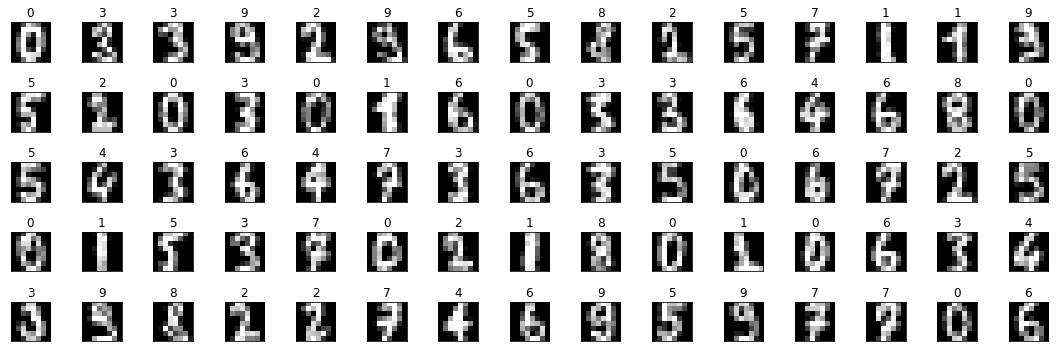

In [25]:
# いくつかのデータに対する手書き数字画像と正解数字
n_im_row, n_im_col = 5, 15
n_im = n_im_row * n_im_col
d = np.arange(D)
d_choice = np.random.choice(np.arange(D),n_im,replace=False)

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

fig = plt.figure(figsize=(n_im_col,n_im_row))
gs = gridspec.GridSpec(n_im_row,n_im_col)
k = 0
for i in np.arange(n_im_row):
    for j in np.arange(n_im_col):
        ax = plt.subplot(gs[i,j])
        ax.imshow(X[d_choice[k],:].reshape(n_px_row,n_px_col),cmap='gray')
        ax.set_title(str(yl[d_choice[k]]))
        ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        ax.tick_params(bottom=False,left=False,right=False,top=False)
        k = k + 1

plt.tight_layout()
plt.show()

In [26]:
# データを訓練用とテスト用に分離
testratio = 0.5
D_test = np.floor(testratio * D).astype('int')
D_train = D - D_test
d = np.arange(D)
d_test = np.random.choice(d,D_test,replace=False)
d_train = np.setdiff1d(d,d_test,assume_unique=True)
X_test = X[d_test,:]
X_train = X[d_train,:]
yl_test = yl[d_test]
yl_train = yl[d_train]
print('訓練データ数：D_train =',D_train)
print('テストデータ数：D_test =',D_test)

訓練データ数：D_train = 899
テストデータ数：D_test = 898


In [27]:
# ターゲットのラベルから1-hot表現への変換
def label2onehot(yl,C):
    D = yl.size
    d = np.arange(D)
    Y = np.zeros((D,C))
    Y[d,yl] = 1
    return(Y)

In [28]:
# ターゲットの1-hot表現
C = 10 # クラス数（0から9までの10クラス）
Y_train = label2onehot(yl_train,C)
Y_test = label2onehot(yl_test,C)

### ニューラルネットワークの初期化

入力層と出力層を含めて3層のニューラルネットワークを用いる．入力層のノード数は64（画像のピクセル数），出力層のノード数は10（数字の個数）である．隠れ層のノード数は16とする．重み$\Theta ^{(l)}$の各成分の初期値は$[-\epsilon ,\epsilon ]$（ただし$\epsilon =\sqrt{6/(n_l +n_{l+1})}$）に属する一様乱数とする．正則化パラメータ$M$の成分はすべて等しいとする．

In [29]:
# ネットワークの構造
n1 = 16
n_list = [n,n1,C]
activation_class = sigmoid
output_class = softmaxOut
cost_fun = crossEntropy
corrtarget_fun = correlation1hotTarget

In [30]:
# ランダムな初期重みベクトル
def randInitWeights(n_list):
    L = len(n_list) - 1
    W_list = []
    for l in range(L):
        m = n_list[l]
        n = n_list[l+1]
        interval = np.sqrt(6 / (m + n))
        W = interval * (2 * np.random.rand(m+1,n) - 1)
        W_list.append(W)
    return(W_list)

In [31]:
# 初期重みの設定
initweight_list = randInitWeights(n_list)

In [32]:
# 正則化パラメータの設定
regprm = 1
regprm_list = [regprm * np.ones(initweight_list[l].shape) for l in range(len(initweight_list))]

### 勾配確認

数値微分によりコスト関数の勾配を求め，誤差逆伝播法で求めた値と数値誤差の範囲内で一致することを確認する．

In [33]:
# ニューラルネットワークの設定
nn = neuralNetwork(initweight_list,regprm_list,activation_class,output_class,cost_fun,corrtarget_fun)

In [34]:
# 初期重みにおけるコストを計算
J = nn.cost(X_train,Y_train)
print('コスト J =',J)

コスト J = 2.4123105735348047


In [35]:
# 誤差逆伝播法と数値微分でコストの勾配を計算
J_W_list = nn.gradCost()
J_W_num_list = nn.numGradCost()

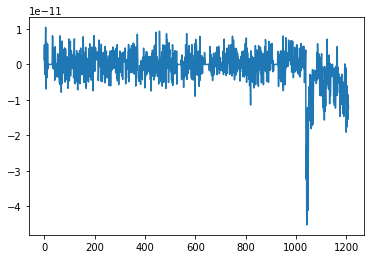

In [36]:
# 誤差逆伝播法と数値微分で求めた勾配の差をプロット
plt.plot(arrlist2vec(J_W_list) - arrlist2vec(J_W_num_list))

### 勾配法と自然勾配法の実行

勾配法を実行すると，学習率$\alpha =0.1$，ステップ数2,000で完全には収束しないが，正解率は訓練データとテストデータ共に高い値となる．

訓練データに対する正解率： 0.9510567296996663
テストデータに対する正解率： 0.9320712694877505


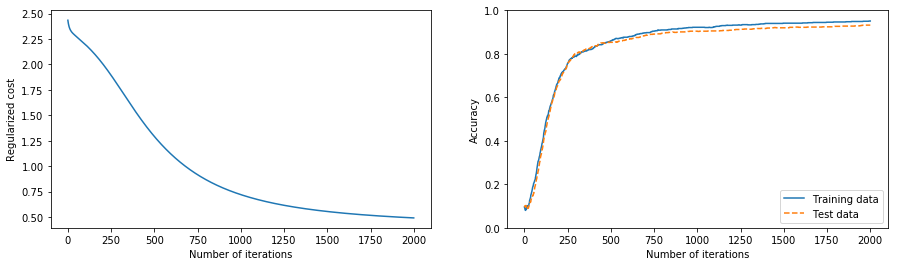

In [38]:
# 正則化あり勾配法の実行
W_list, J_history, acc_train_history, acc_test_history, ypl_train, ypl_test = gradDesReg_nn_cls(initweight_list,regprm_list,
                                                                                           X_train,Y_train,X_test,Y_test,activation_class=sigmoid,learnrate=0.1,numiters=2000)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストと正解率のプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(J_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

予測が外れた訓練データ，テストデータに対して手書き数字画像と正解数字，予測数字を見てみよう．

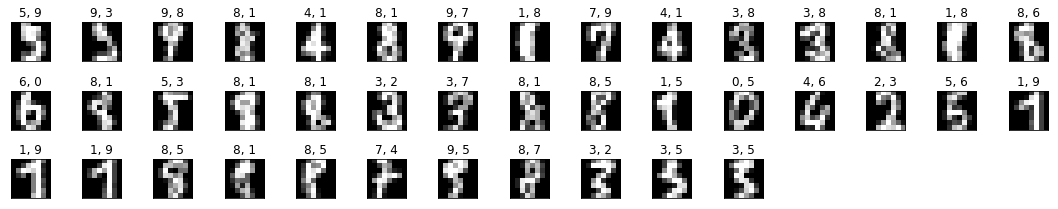

In [38]:
# 予測が外れたすべての訓練データに対する手書き数字画像と正解数字，予測数字
I_incorrect = (ypl_train != yl_train)
d = np.arange(D_train)[I_incorrect]
n_im = np.sum(I_incorrect)
n_im_col = 15
n_im_row = np.ceil(n_im/n_im_col).astype('int')

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

fig = plt.figure(figsize=(n_im_col,n_im_row))
gs = gridspec.GridSpec(n_im_row,n_im_col)
for k in np.arange(n_im):
    i, j = divmod(k,n_im_col)
    ax = plt.subplot(gs[i,j])
    ax.imshow(X_train[d[k],:].reshape(n_px_row,n_px_col),cmap='gray')
    ax.set_title(str(yl_train[d[k]]) + ', ' + str(ypl_train[d[k]]))
    ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
    ax.tick_params(bottom=False,left=False,right=False,top=False)

plt.tight_layout()
plt.show()

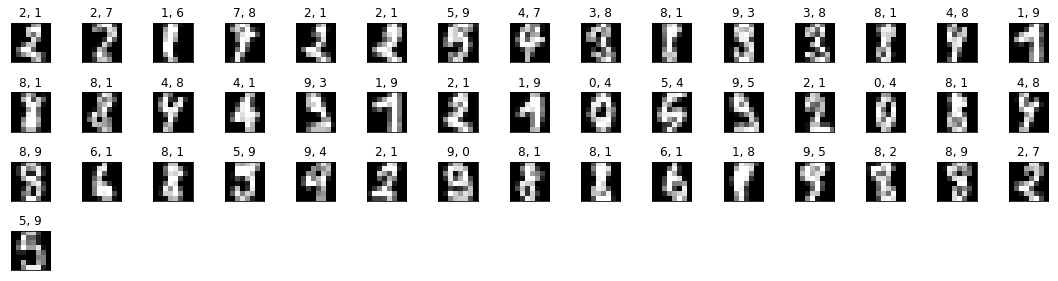

In [39]:
# 予測が外れたすべてのテストデータに対する手書き数字画像と正解数字，予測数字
I_incorrect = (ypl_test != yl_test)
d = np.arange(D_test)[I_incorrect]
n_im = np.sum(I_incorrect)
n_im_col = 15
n_im_row = np.ceil(n_im/n_im_col).astype('int')

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

fig = plt.figure(figsize=(n_im_col,n_im_row))
gs = gridspec.GridSpec(n_im_row,n_im_col)
for k in np.arange(n_im):
    i, j = divmod(k,n_im_col)
    ax = plt.subplot(gs[i,j])
    ax.imshow(X_test[d[k],:].reshape(n_px_row,n_px_col),cmap='gray')
    ax.set_title(str(yl_test[d[k]]) + ', ' + str(ypl_test[d[k]]))
    ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
    ax.tick_params(bottom=False,left=False,right=False,top=False)

plt.tight_layout()
plt.show()

自然勾配法を実行すると，学習率$\alpha =0.1$のときわずか50ステップでほぼ収束し，正解率も通常の勾配法よりも高い値となる．

訓練データに対する正解率： 0.9888765294771968
テストデータに対する正解率： 0.9766146993318485


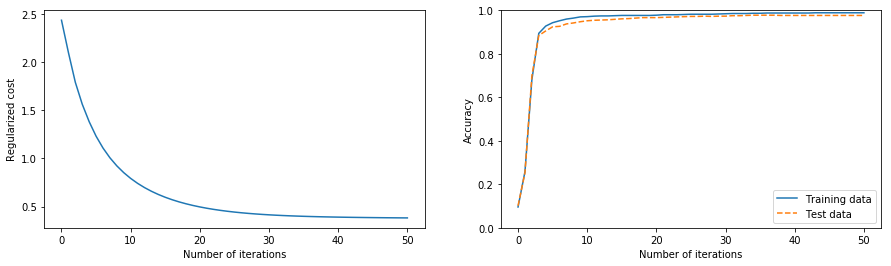

In [39]:
# 正則化あり自然勾配法の実行
W_list, J_history, acc_train_history, acc_test_history, ypl_train, ypl_test = natGradDesReg_nn_cls(initweight_list,regprm_list,
                                                                                           X_train,Y_train,X_test,Y_test,activation_class=sigmoid,learnrate=0.1,numiters=50)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストと正解率のプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(J_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

Fisher情報行列を各層内の成分だけ残したブロック対角行列で近似した場合も，全成分を計算した通常の自然勾配法と同程度の性能を発揮する．

訓練データに対する正解率： 0.9888765294771968
テストデータに対する正解率： 0.9732739420935412


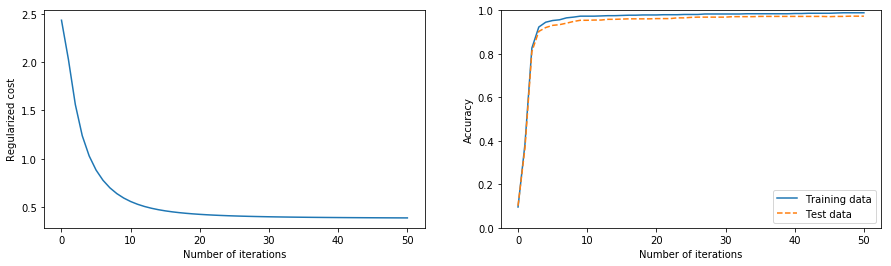

In [40]:
# 正則化あり層内自然勾配法の実行
W_list, J_history, acc_train_history, acc_test_history, ypl_train, ypl_test = inLayerNatGradDesReg_nn_cls(initweight_list,regprm_list,
                                                                                           X_train,Y_train,X_test,Y_test,activation_class=sigmoid,learnrate=0.1,numiters=50)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストと正解率のプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(J_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

一方，Fisher情報行列に含まれる転送行列の個数が少ない成分だけ残した近似はあまり性能がよくない．0次の近似（すなわち出力層内のFisher情報行列のみ計算して正則化項を加える）は通常の勾配法よりは性能がいいが，学習率$\alpha =0.003$のとき収束に500回以上かかる．また，1次の近似（$g^{(1,1)}$, $g^{(1,0)}$, $g^{(0,1)}$のみ計算して正則化項を加える）では，コストが単調減少せず不安定な振る舞いをする．

訓練データに対する正解率： 0.9721913236929922
テストデータに対する正解率： 0.9599109131403119


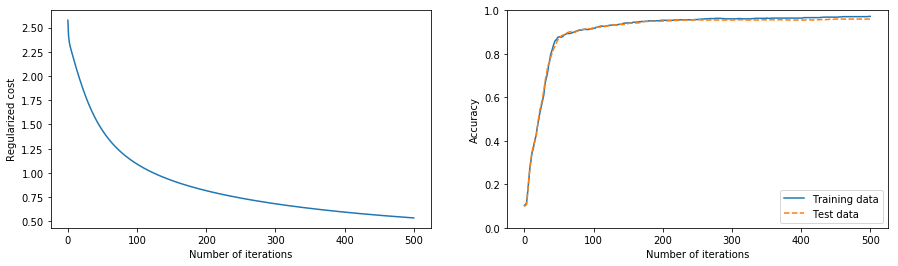

In [42]:
# 転送回数を0次で打ち切った正則化あり自然勾配法の実行
W_list, J_history, acc_train_history, acc_test_history, ypl_train, ypl_test = cutTrfNatGradDesReg_nn_cls(initweight_list,regprm_list,
                                                                                           X_train,Y_train,X_test,Y_test,activation_class=sigmoid,learnrate=0.003,numiters=500,
                                                                                                         deg=0)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストと正解率のプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(J_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

訓練データに対する正解率： 0.10233592880978866
テストデータに対する正解率： 0.09910913140311804


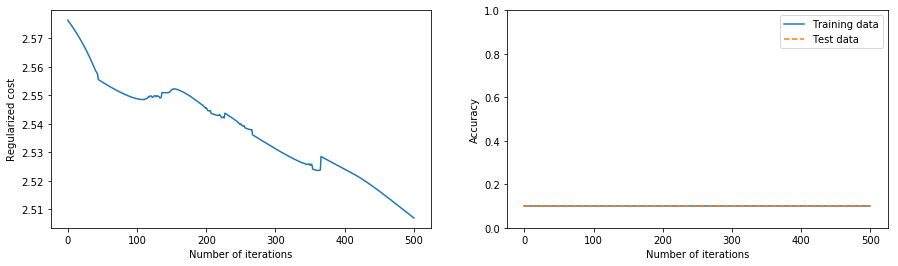

In [43]:
# 転送回数を1次で打ち切った正則化あり自然勾配法の実行
W_list, J_history, acc_train_history, acc_test_history, ypl_train, ypl_test = cutTrfNatGradDesReg_nn_cls(initweight_list,regprm_list,
                                                                                           X_train,Y_train,X_test,Y_test,activation_class=sigmoid,learnrate=0.00003,numiters=500,
                                                                                                         deg=1)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストと正解率のプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(J_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

### ReLU関数の使用

これまでは隠れ層の活性化関数としてシグモイド関数を用いてきたが，次はReLU関数を用いて実験する．勾配法，自然勾配法およびFisher情報行列を各層内の成分だけ残した自然勾配法では，ReLU関数を用いた方が性能がよくなる．一方，Fisher情報行列の中で転送回数の少ない成分だけ残した場合，0次近似ではシグモイド関数よりもReLU関数を用いた方が若干性能が悪くなっているように見える．また，1次近似ではコストが収束しない．

訓練データに対する正解率： 0.9699666295884316
テストデータに対する正解率： 0.9454342984409799


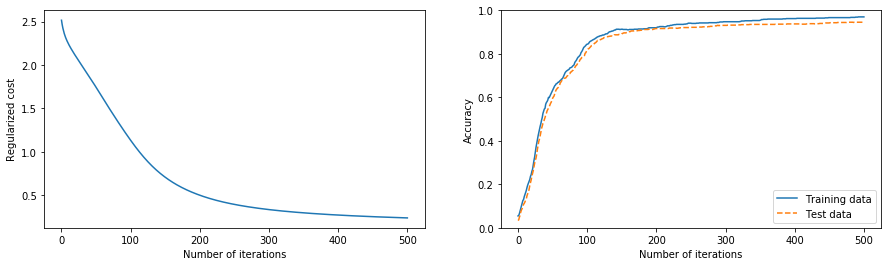

In [41]:
# 正則化あり勾配法の実行
W_list, J_history, acc_train_history, acc_test_history, ypl_train, ypl_test = gradDesReg_nn_cls(initweight_list,regprm_list,
                                                                                           X_train,Y_train,X_test,Y_test,activation_class=relu,learnrate=0.1,numiters=500)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストと正解率のプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(J_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

訓練データに対する正解率： 0.9988876529477196
テストデータに対する正解率： 0.9799554565701559


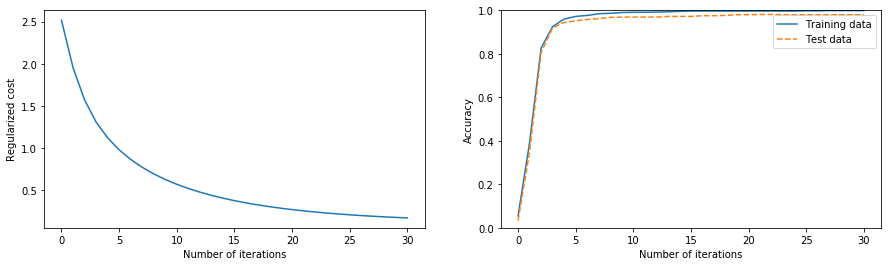

In [42]:
# 正則化あり自然勾配法の実行
W_list, J_history, acc_train_history, acc_test_history, ypl_train, ypl_test = natGradDesReg_nn_cls(initweight_list,regprm_list,
                                                                                           X_train,Y_train,X_test,Y_test,activation_class=relu,learnrate=0.1,numiters=30)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストと正解率のプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(J_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

訓練データに対する正解率： 0.996662958843159
テストデータに対する正解率： 0.9799554565701559


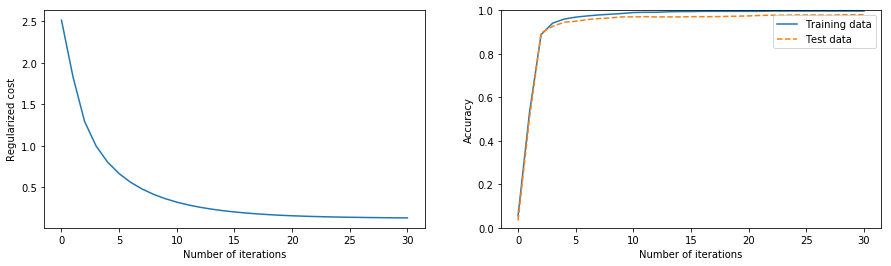

In [43]:
# 正則化あり層内自然勾配法の実行
W_list, J_history, acc_train_history, acc_test_history, ypl_train, ypl_test = inLayerNatGradDesReg_nn_cls(initweight_list,regprm_list,
                                                                                           X_train,Y_train,X_test,Y_test,activation_class=relu,learnrate=0.1,numiters=30)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストと正解率のプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(J_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

訓練データに対する正解率： 0.96440489432703
テストデータに対する正解率： 0.9487750556792873


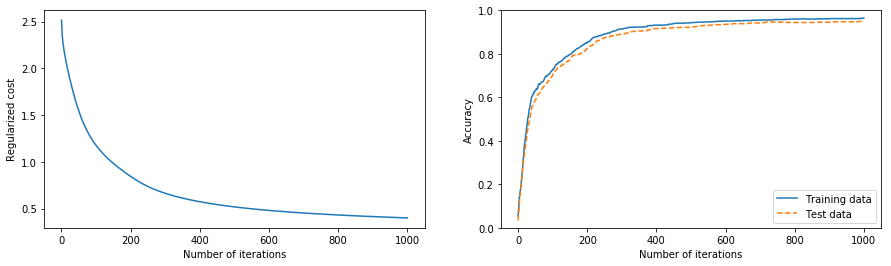

In [46]:
# 転送回数を0次で打ち切った正則化あり自然勾配法の実行
W_list, J_history, acc_train_history, acc_test_history, ypl_train, ypl_test = cutTrfNatGradDesReg_nn_cls(initweight_list,regprm_list,
                                                                                           X_train,Y_train,X_test,Y_test,activation_class=relu,learnrate=0.0003,numiters=1000,
                                                                                                         deg=0)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストと正解率のプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(J_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()

訓練データに対する正解率： 0.11568409343715239
テストデータに対する正解率： 0.09688195991091314


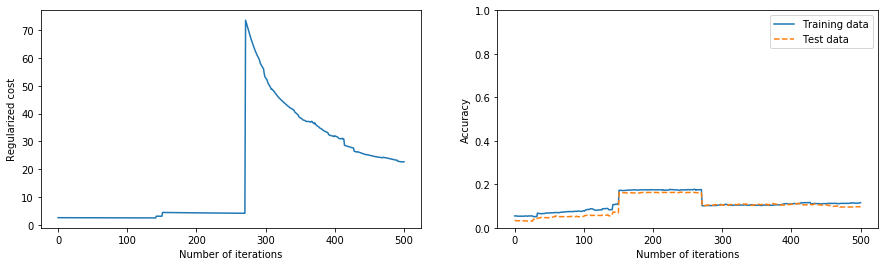

In [47]:
# 転送回数を1次で打ち切った正則化あり自然勾配法の実行
W_list, J_history, acc_train_history, acc_test_history, ypl_train, ypl_test = cutTrfNatGradDesReg_nn_cls(initweight_list,regprm_list,
                                                                                           X_train,Y_train,X_test,Y_test,activation_class=relu,learnrate=0.00003,numiters=500,
                                                                                                         deg=1)
print('訓練データに対する正解率：',acc_train_history[-1])
print('テストデータに対する正解率：',acc_test_history[-1])

# コストと正解率のプロット
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,2)
ax0 = plt.subplot(gs[0,0])
ax0.plot(J_history)
ax0.set_xlabel('Number of iterations')
ax0.set_ylabel('Regularized cost')
ax1 = plt.subplot(gs[0,1])
ax1.plot(acc_train_history,'-',label='Training data')
ax1.plot(acc_test_history,'--',label='Test data')
ax1.set_xlabel('Number of iterations')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0,1])
ax1.legend()